In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES = 2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple
import json 
import gc

import cv2
import PIL 

import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train_procedure, get_augmented_transforms, load_model, plot_models
from models import VGG16, VGG11, VGG_tiny, Resnet, ResnetD, ResNext

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = True

SIZE = 224
batch_size = 16

In [5]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(directory=TRAIN_PATH, out_path=TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(directory=VAL_PATH, out_path=VAL_LABELS_CSV_PATH)

In [6]:
train_labels, val_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH), pd.read_csv(VAL_LABELS_CSV_PATH)

mean, std = get_norm_stats(data_path=TRAIN_LABELS_CSV_PATH)

val_transform = get_transforms(mean=mean, std=std)
train_transform = get_augmented_transforms(mean=mean, std=std) if AUGMENT else get_transforms(mean=mean, std=std)

train_dataset = ImagenetteDataset(labels_csv_path=TRAIN_LABELS_CSV_PATH, transform=train_transform)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(labels_csv_path=VAL_LABELS_CSV_PATH, transform=val_transform)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

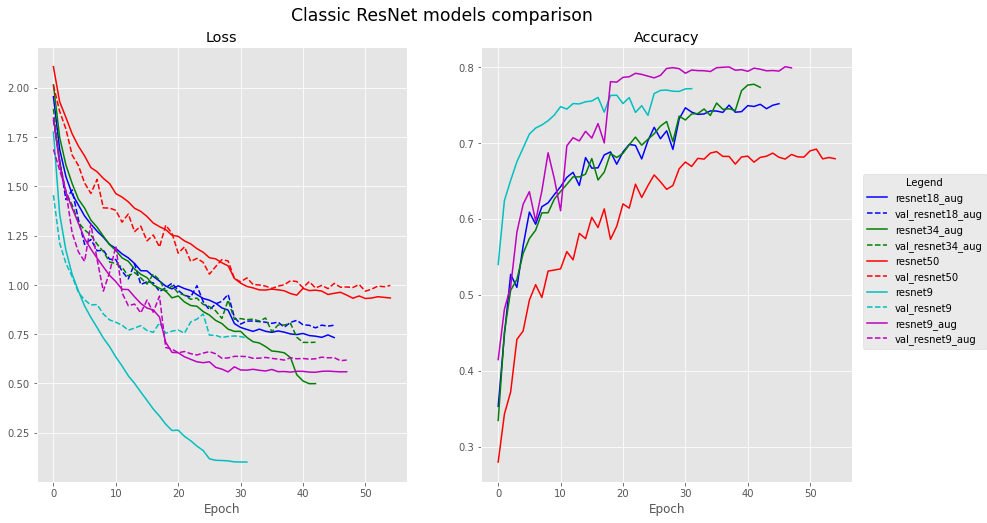

In [7]:
plot_models(['logs_resnet18.json','logs_resnet34.json',
             'logs_resnet50.json', 'logs_resnet9.json', 'logs_resnet9_aug.json'],
            title='Classic ResNet models comparison')

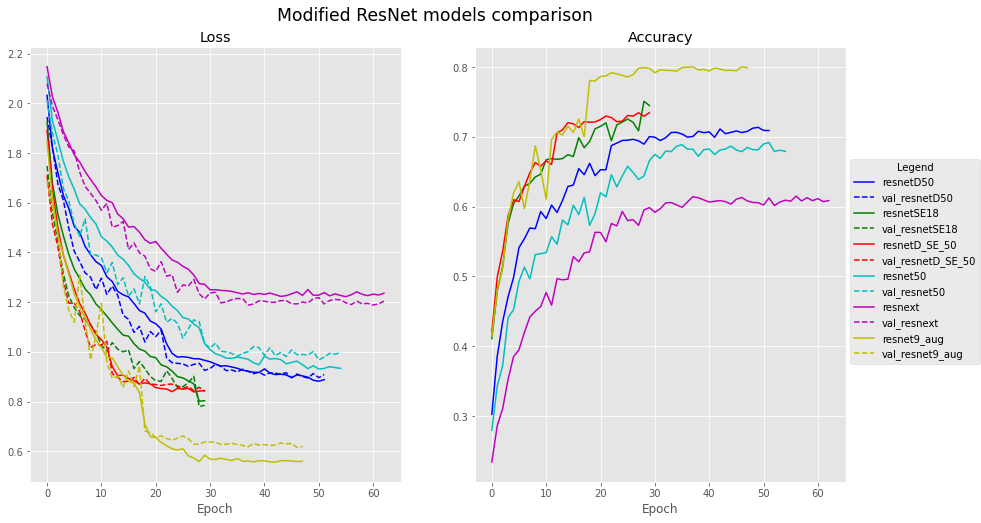

In [8]:
plot_models(['logs_resnetD50.json','logs_resnetSE18.json', 'logs_resnetD_SE_50.json',
             'logs_resnet50.json', 'logs_resnext.json', 'logs_resnet9_aug.json'],
            title='Modified ResNet models comparison')

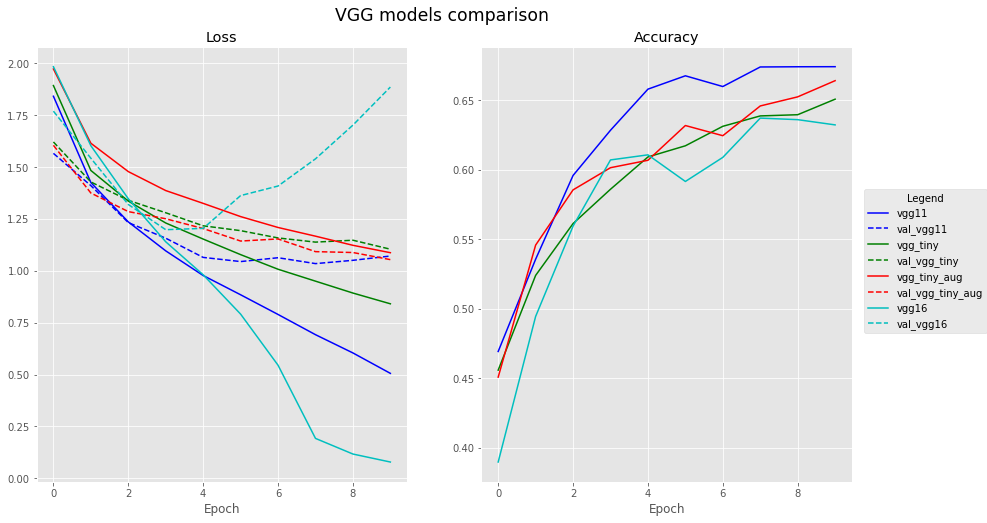

In [9]:
plot_models(['logs_vgg11.json', 'logs_vgg_tiny.json', 'logs_vgg_tiny_aug.json','logs_vgg16.json'],
            title='VGG models comparison')

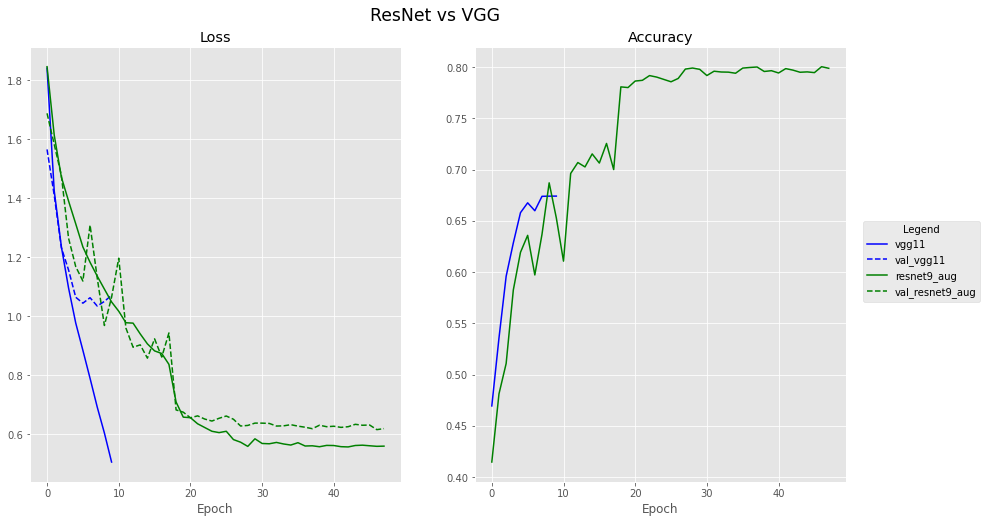

In [10]:
plot_models(['logs_vgg11.json','logs_resnet9_aug.json' ],
            title='ResNet vs VGG')

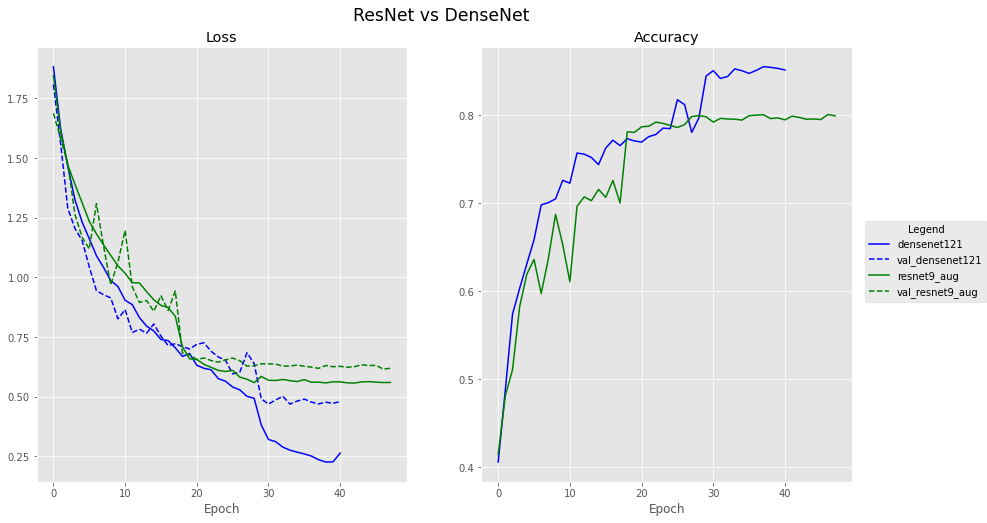

In [ ]:
plot_models(['logs_densenet121.json','logs_resnet9_aug.json' ],
            title='ResNet vs DenseNet')

In [11]:
# best Resnet prediction analysis 
if 'model' in locals():
    del model 
    
model = Resnet(num_layers=9)
ckpt_path = "saves/ckpts3/resnet9_aug_model.pt"
    
checkpoint = torch.load(ckpt_path, device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

model.eval()

class_shot = np.zeros(10)
class_cnt = np.zeros(10)
predictions = np.array([0])
labels_true = np.array([0])
mistake_imgs = {i: [] for i in range(10)}
mistake_preds = {i: [] for i in range(10)}
mistake_labels = {i: [] for i in range(10)}
with torch.no_grad():
    for i, (imgs, labels) in enumerate(val_dataloader):
        imgs = imgs.to(device)
        labels = labels.numpy().astype(int)
        predictions_batch = model(imgs).argmax(axis=1).detach().cpu().numpy().astype(int)
        
        mistake_ids = np.where(labels != predictions_batch)[0]
        if len(mistake_ids) > 0:
            for ind in mistake_ids:
                if len(mistake_imgs[labels[ind]]) < 5:
                    mistake_imgs[labels[ind]].append(imgs[ind].clone().detach().cpu())
                    mistake_labels[labels[ind]].append(labels[ind])
                    mistake_preds[labels[ind]].append(predictions_batch[ind])
        for ind, label in enumerate(labels):
            if label == predictions_batch[ind]:
                class_shot[label] += 1
            class_cnt[label] += 1
            
        predictions = np.concatenate((predictions, predictions_batch), axis=None)
        labels_true = np.concatenate((labels_true, labels), axis=None)
        
predictions, labels_true = predictions[1:], labels_true[1:]
predictions.shape, labels_true.shape, len(mistake_imgs[0]), len(mistake_labels[0]), len(mistake_preds[0])

((3925,), (3925,), 5, 5, 5)

In [12]:
accuracy_score(labels_true, predictions)

0.7997452229299363

In [13]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]

for ind, label in enumerate(class_shot):
    print(f'accuracy of class {class_names[ind]}: {label / class_cnt[ind]}')

accuracy of class church: 0.8264058679706602
accuracy of class fish: 0.896640826873385
accuracy of class truck: 0.7969151670951157
accuracy of class good boy: 0.8886075949367088
accuracy of class disco: 0.8515406162464986
accuracy of class chute: 0.8512820512820513
accuracy of class gas station: 0.6229116945107399
accuracy of class chainsaw: 0.6632124352331606
accuracy of class french horn: 0.7766497461928934
accuracy of class golf ball: 0.8370927318295739


In [14]:
confusion_matrix(labels_true, predictions)

array([[338,   3,   9,   5,  11,   9,  12,  10,   7,   5],
       [  4, 347,   2,   3,   6,   1,   3,   5,   0,  16],
       [ 13,   5, 310,   2,  10,   3,  19,  15,  10,   2],
       [  4,   5,   7, 351,   1,   1,   3,  11,   2,  10],
       [  5,   0,   7,   4, 304,   2,  18,   6,   9,   2],
       [ 19,   2,   6,   5,   3, 332,   5,   7,   0,  11],
       [ 23,   1,  36,   3,  43,   3, 261,  25,  17,   7],
       [ 19,  12,  13,  11,  24,  10,  22, 256,   6,  13],
       [ 17,   9,   8,   6,  16,   0,  14,  12, 306,   6],
       [ 19,   7,   3,   5,  10,   8,   2,   8,   3, 334]])

/tmp/ipykernel_59105/3018092470.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax[j, i].imshow(renorm(torch.tensor(images[j])))


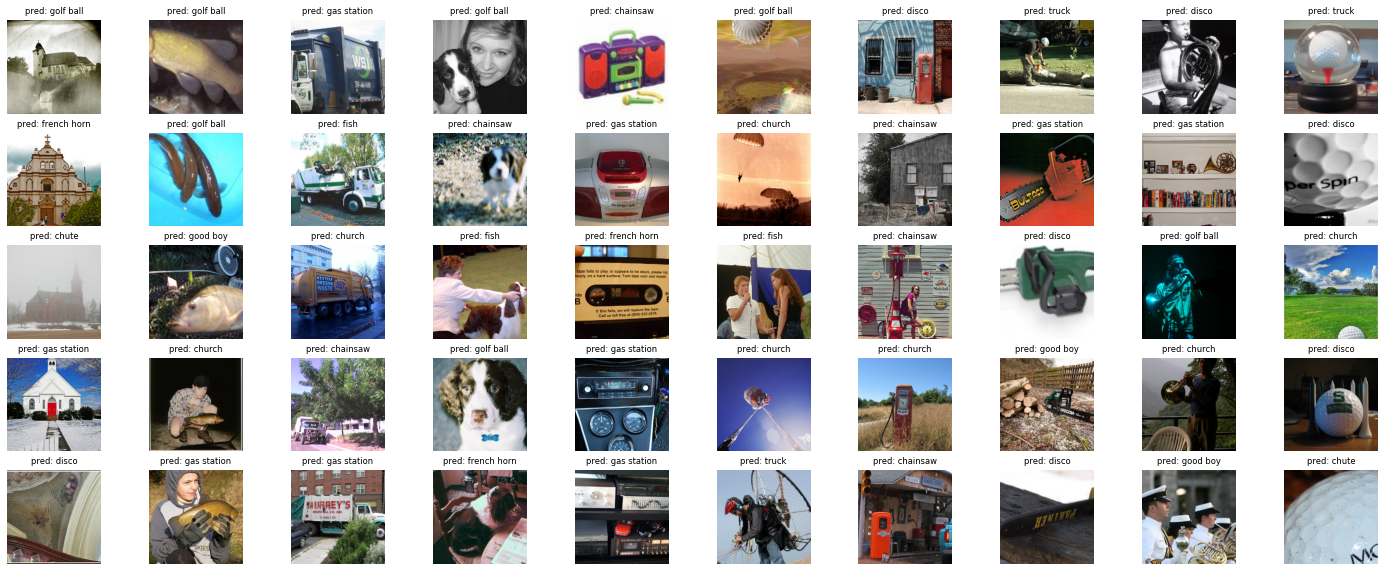

In [15]:
renorm = T.Compose(
    [
     T.Normalize(mean=(0,0,0), std = 1. / np.array(std)),
    T.Normalize(mean=-np.array(mean), std=(1., 1., 1.)), 
    T.ToPILImage(mode='RGB')
    ] 
    )

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(25, 10))
for i in range(10):
    labels= mistake_labels[i]
    images = mistake_imgs[i]
    preds = mistake_preds[i]
    for j in range(5):
        ax[j, i].imshow(renorm(torch.tensor(images[j])))
        ax[j, i].set_title(f'pred: {class_names[preds[j]]}', fontsize='small')
        ax[j, i].axis('off')
    
plt.show();